In [130]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [131]:
import scipy.io as sio
import numpy as np
import scipy
import os
import warnings
import pandas as pd

from ripple_detection import Karlsson_ripple_detector, Kay_ripple_detector
from ripple_detection.simulate import simulate_time
from scipy import signal

warnings.simplefilter(action='ignore', category=FutureWarning)

In [132]:
from generate_data_files import read_out_arrays, generate_data_set_for_animal

In [133]:
data_path='../data/m4000series_LFP_ripple.mat'
data = sio.loadmat(data_path)
animal = 'm4015_session2'

sf=2.5e3
q=2

In [134]:
# res = generate_data_set_for_animal(data, key, )

In [135]:
lfp, speed, ripple_index = read_out_arrays(data[animal])

time = simulate_time(lfp.shape[0], sf)
ripple_times = time[ripple_index]
lfp = lfp.flatten()

def perform_high_pass_filter(lfp, low_cut_frequency, high_cut_frequency, sf):
        wn = sf / 2.
        b, a = signal.butter(5, [low_cut_frequency/wn, high_cut_frequency/wn], 'bandpass')
        lfp = signal.filtfilt(b, a, lfp)
        return lfp

lfp = perform_high_pass_filter(lfp, 1, 500, sf)

speed = scipy.signal.decimate(speed.flatten(), q)
lfp = scipy.signal.decimate(lfp.flatten(), q)
time = simulate_time(lfp.shape[0], sf/q)


lfp = lfp[:, np.newaxis]
ripples = Kay_ripple_detector(time, lfp, speed.flatten(), sf/q)

ripple_time_index_sparse = list()
for t in ripple_times:
    ripple_time_index_sparse.append(np.argmin(np.abs(t-time)))
    
    

In [136]:
ripples['duration'] = ripples.loc[:,'end_time'] - ripples.loc[:,'start_time']
ripples['start_index'] = ripples.apply(lambda row: int(np.argwhere(time==(row['start_time']))), axis=1)
ripples['end_index'] = ripples.apply(lambda row: int(np.argwhere(time==(row['end_time']))), axis=1)
ripples['duration_index'] = ripples.apply(lambda row: row['end_index']-row['start_index'], axis=1)

ripples['speed'] = ripples.apply(lambda row: speed[int(row['start_index']):int(row['end_index'])], axis=1)
ripples['lfp'] = ripples.apply(lambda row: lfp[int(row['start_index']):int(row['end_index']),:], axis=1)
ripples['time'] = ripples.apply(lambda row: time[int(row['start_index']):int(row['end_index'])], axis=1)


end_time = np.array(ripples.end_time)
start_time = np.array(ripples.start_time)
assert end_time.shape==start_time.shape
n_ripples = end_time.shape[0]
label = np.zeros(n_ripples)
for i in range(n_ripples):
    for j in range(ripple_times.shape[0]):
        if np.logical_and(start_time[i]<=ripple_times[j], ripple_times[j]<=end_time[i]):
            label[i] = 1
            
ripples['labels'] = label

In [137]:
ripples.lfp

ripple_number
1      [[-0.04472132147480444], [0.014097619687614662...
2      [[0.0686375116888524], [0.048257645526740146],...
3      [[0.2265477605307952], [0.2557319256464237], [...
4      [[-0.17030643239608914], [-0.1560375511234284]...
5      [[-0.05489022059286357], [-0.08856192358058432...
6      [[-0.053586889332341264], [-0.0660094484190796...
7      [[0.020722263373441605], [0.008922353069946916...
8      [[0.12758195861227853], [0.15314665646307313],...
9      [[-0.03672898849915007], [-0.01978862197806563...
10     [[0.08726599573692513], [0.0647221640881622], ...
11     [[-0.16448255943711346], [-0.17223315231837333...
12     [[0.24682427484147507], [0.23527815388763298],...
13     [[-0.24131047410133324], [-0.2646589018400738]...
14     [[0.12401501864268454], [0.13127117219200088],...
15     [[0.011410796122989245], [0.03940502951044599]...
16     [[0.14197560760426084], [0.14765497752382317],...
17     [[-0.45092377525089117], [-0.45623801930485014...
18     [[0.063085

(500,)

array([[1, 2, 0],
       [3, 4, 0]])

<IPython.core.display.Javascript object>


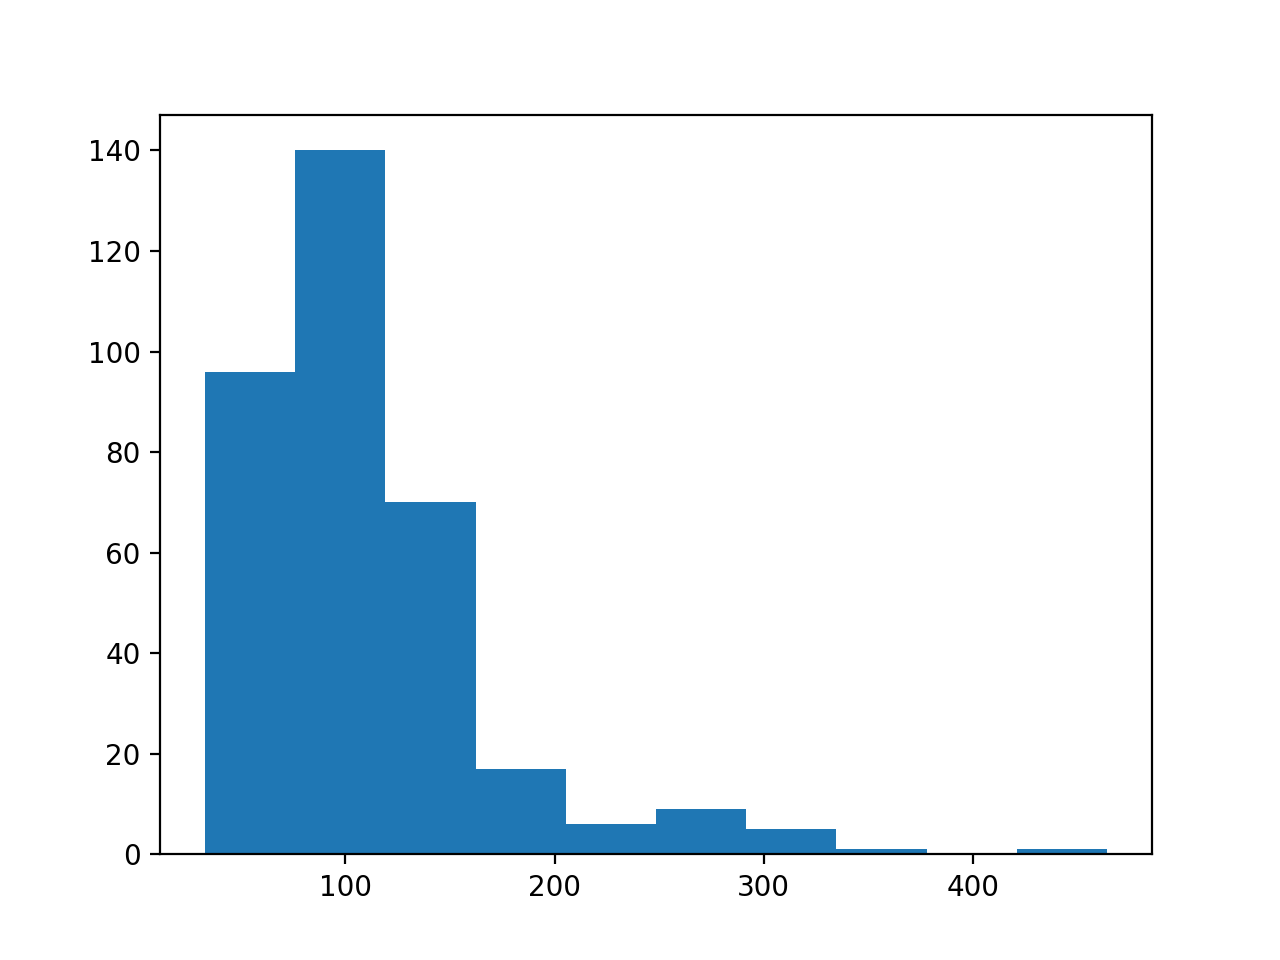

In [155]:
plt.figure()
plt.hist(ripples.duration_index)
plt.show()

<IPython.core.display.Javascript object>


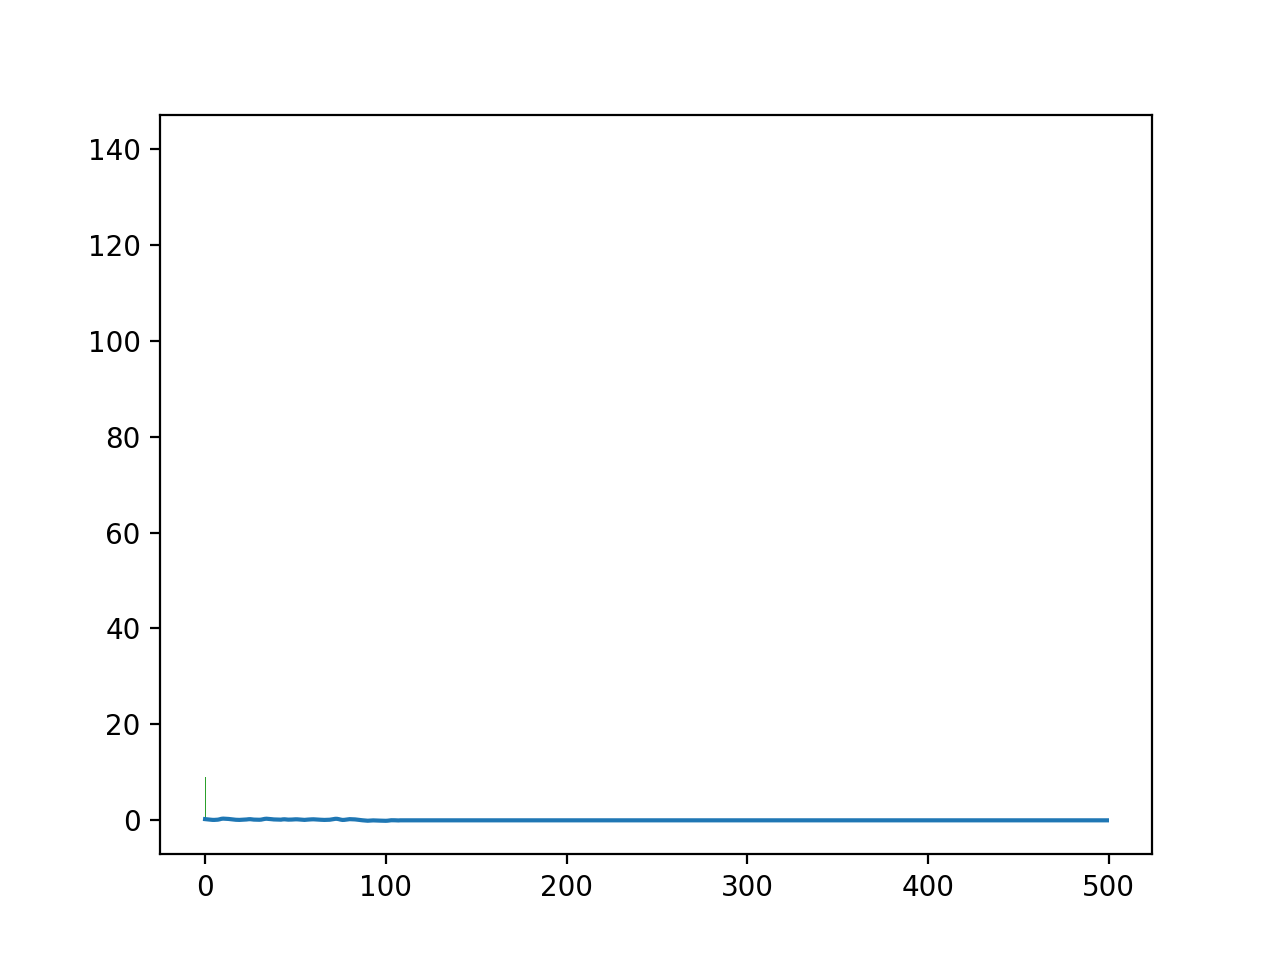

In [151]:
import matplotlib.pyplot as plt
plt.plot(ripples.loc[50,'lfp'])